In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.monitor import *

import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble

import time

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
backend_overview()

#GLOBAL VARIABLES
n_qubits = 1
n_shots = 1000
shift = np.pi/2
n_parameters = 3

momentum = 0.5

# simulator = qiskit.Aer.get_backend('qasm_simulator')
#can choose the simulator or the real quantum computer. The name of the variable is always 'simulator'
from qiskit.providers.ibmq import least_busy
from qiskit import IBMQ
simulator = least_busy(provider.backends(operational = True, simulator=False, status_msg='active',
                                       filters=lambda x: x.configuration().n_qubits > 1)) 
simulator = provider.get_backend('ibmq_belem')
print("We are executing on...",simulator)
print("It has",simulator.status().pending_jobs,"pending jobs")


ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 53             Pending Jobs: 5              Pending Jobs: 1
Least busy:   False          Least busy:   False          Least busy:   True
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      174.4          Avg. T1:      89.3           Avg. T1:      94.1
Avg. T2:      56.6           Avg. T2:      86.6           Avg. T2:      97.3



ibmq_lima                    ibmq_bogota                  ibmq_santiago
---------                    -----------                  -------------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 5              Pending Jobs: 96             Pending Jobs: 9
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Oper

In [2]:
class QuantumCircuit:
    """
    This class provides an interface to interact with our Quantum Circuit
    """

    def __init__(self, n_qubits, backend, shots):

        #-----Circuit definition
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        self.parameters = qiskit.circuit.ParameterVector('parameters', 3)

        all_qubits = [i for i in range (n_qubits)]#qubits vector

        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.u(self.parameters[0], self.parameters[1], self.parameters[2], all_qubits)
        self._circuit.measure_all()
        #-----
        
        self.backend = backend
        self.shots = shots
        self.n_qubits = n_qubits
        
    def draw(self):
        self._circuit.draw(output ='mpl')

    def expectation_Z(self,counts, shots, n_qubits):
        expects = np.zeros(n_qubits)
        for key in counts.keys():
            percentage = counts[key]/shots
            check = np.array([(float(key[i]))*percentage for i in range(n_qubits)])
            expects += check
        return expects


    def run(self, thetas):
        #acting on a simulator
        thetas = thetas.squeeze()
        p_circuit = self._circuit.bind_parameters({self.parameters[k]: thetas[k].item() for k in range(len(thetas))})
        job_sim = qiskit.execute(p_circuit,
                          self.backend,
                          shots=self.shots)

        result = job_sim.result()
        print("time", result.time_taken)
        counts = result.get_counts(p_circuit)
        #print(counts['0'], counts['1'])

        return self.expectation_Z(counts, self.shots, self.n_qubits)




In [3]:
circuit = QuantumCircuit(n_qubits, simulator, n_shots)

print(circuit._circuit)
circuit._circuit.draw(output = 'mpl', filename = 'U3_circuit.png')#to print as a pyplot figure (new library needed)


rotation = torch.Tensor([np.pi/4]*3)
exp = circuit.run(rotation)
print('Expected value for rotation pi: {}'.format(exp))



        ┌───┐ ░ ┌──────────────────────────────────────────────┐ ░ ┌─┐
     q: ┤ H ├─░─┤ U(parameters[0],parameters[1],parameters[2]) ├─░─┤M├
        └───┘ ░ └──────────────────────────────────────────────┘ ░ └╥┘
meas: 1/════════════════════════════════════════════════════════════╩═
                                                                    0 
time 2.613339900970459
Expected value for rotation pi: [0.737]


In [4]:
class HybridFunction(Function):
    """Hybrid quantum-classical function definition"""

    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """Forward pass computation"""
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
       # context variable (it may take multiple values and return them related to the context). Used to keep track for backpropagation

        expectation_z = ctx.quantum_circuit.run(input)  # evaluating model with trainable parameter
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)  # saves a given tensor for a future call to backward (trainable parameter and the result obtained)
    # input=parameters (3), result=resut of quantum operation (1)

        return result

    @staticmethod
    def backward(ctx, grad_output): #grad_output os previous gradient
        """Backward computation"""

        input, expectation = ctx.saved_tensors #evaluated in forward
        input = torch.reshape(input, (-1,))
        gradients = torch.Tensor()

        #iterating to evaluate gradient
        for k in range(len(input)):
            #shifting parameters
            shift_right, shift_left = input.detach().clone(), input.detach().clone()
            shift_right[k] += ctx.shift
            shift_left[k] -= ctx.shift

            # evaluating model after shift
            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            #evaluating gradient with finite difference formula
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])

            gradients = torch.cat((gradients, gradient.float()))

        result = gradients.float() * grad_output.float()

        return (result).T, None, None
        #returns the chain of previous gradient and evaluated gradient

In [5]:
class Hybrid(nn.Module):
    """Hybrid quantum-cassical layer definition"""

    def __init__(self, n_qubits ,backend, shots, shift):
        super(Hybrid, self).__init__()

        self.quantum_circuit = QuantumCircuit(n_qubits, backend, shots)
        self.shift = shift #parameter shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift) #calling forward and backward


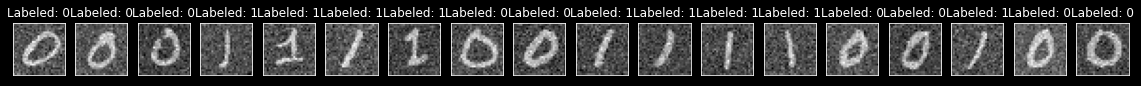

In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=5):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)





#DATA LOADING
#training data, can chose whether to use a noisy set of training data
n_samples = 50
std_dv, mean = 0.20, 0
# X_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
X_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), 
                                                                                                AddGaussianNoise(mean, std_dv)]))
#keeping only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples])


X_train.data = X_train.data[idx] #tensor values
X_train.targets = X_train.targets[idx]#tensor labels

#making batches (dim = 1). Ir returns an iterable(pytorch tensor)
train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)
data_iter = iter(train_loader)#making the iterable an iterator, an object with the next method that can be used in a for cycle


#showing samples
n_samples_show = 18
fig, axes = plt.subplots(nrows=1, ncols=int(n_samples_show), figsize=(20, 3))
#subolot returns the figure and axis that are indipendent as default

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[int(n_samples_show) - 1].imshow(images[0].numpy().squeeze(), cmap='gray')#squeeze removes unuseful dim(1). Converting into a numpy vector
    axes[int(n_samples_show) - 1].set_xticks([])
    axes[int(n_samples_show) - 1].set_yticks([])
    axes[int(n_samples_show) - 1].set_title("Labeled: {}".format(targets.item()))

    n_samples_show -= 1




#validation data
n_samples = 25

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)






In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5) #input = gray scale
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d() #deactivating randomly some neurons to avoid overfitting
        self.fc1 = nn.Linear(256, 64) #input dimension: CH(16) x Matrix_dim
        self.fc2 = nn.Linear(64,3)
        self.hybrid = Hybrid(n_qubits, simulator, n_shots, shift )
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = self.dropout(x)
        x = x.view(1,-1) #reshaping tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x) #calling the forward method

        return torch.cat((x, 1-x),-1)#returning probabilities



#######################
#TRAINING AND TESTING
#function to train the nn
def training_loop (n_epochs, optimizer, model, loss_fn, train_loader):
    loss_values = []
    for epoch in range(0, n_epochs, +1):
        total_loss = []

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()#getting rid of previous gradients

            output = model(data)#forward pass
            loss = loss_fn(output, target)
            loss.backward()

            optimizer.step()#updating parameters
            total_loss.append(loss.item())#item transforms into a number

        loss_values.append(sum(total_loss)/len(total_loss))#obtainign the average loss
        print('Training [{:.0f}%]   Loss: {:.4f}'.format(100*(epoch+1)/n_epochs, loss_values[-1]))

    return loss_values


In [8]:
#Training the NN
#we can use any optimizer, learning rate and cost/loss function to train over multiple epochs
learning_rate=0.01
model = Net()
params = list(model.parameters())
epochs = 20

optimizer = optim.SGD(params, learning_rate, momentum=momentum)
loss_func = nn.CrossEntropyLoss()

loss_list = []
model.train() #training the module in training mode(specifying the intention to the layers). Used for dropout or batchnorm

begin = time.time()
loss_list = (training_loop(epochs, optimizer, model, loss_func, train_loader))
end = time.time()


#plotting the training graph
plt.figure(num=2)
plt.plot(loss_list)
plt.title('Hybrid NN Training convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')
plt.savefig('TC_U3.pdf')



#defining a function to test our net
def validate(model, test_loader, loss_function, n_test, axes):
    correct = 0
    total_loss = []
    count = 0

    with torch.no_grad():  # disabling the gradient as we don't want to update parameters
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)  #evaluating the model on test data

            # evaluating the accuracy of our model
            pred = output.argmax(dim=1,
                                 keepdim=True)  # we are interested in the max value of probability
            correct += pred.eq(target.view_as(pred)).sum().item()  # checking if it matches with label

            #evluating loss function
            loss = loss_function(output, target)
            total_loss.append(loss.item())

            #printing the resut as images
            if count >= n_test:
                continue
            else:
                axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

                axes[count].set_xticks([])
                axes[count].set_yticks([])
                axes[count].set_title('P: {}'.format(pred.item()))
            count += 1

        print('Performance on test data: \n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'
              .format(sum(total_loss)/len(total_loss),(correct / len(test_loader))*100))

#TESTING THE NN

time 2.710479259490967


C:\Users\devik\AppData\Local\Temp/ipykernel_25264/830401251.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  result = torch.tensor([expectation_z])


time 2.71227765083313
time 2.8645966053009033
time 2.7069616317749023
time 2.74062442779541
time 2.7160980701446533
time 3.4505069255828857
time 2.9685425758361816
time 2.718512773513794
time 2.8348262310028076
time 2.7980244159698486
time 2.764512538909912
time 2.707101345062256
time 2.629955768585205
time 2.7382020950317383
time 2.7474257946014404
time 2.75933575630188
time 2.6158623695373535
time 2.7115318775177
time 2.7468931674957275
time 2.6886844635009766
time 2.7118284702301025
time 2.7346091270446777
time 2.668386459350586
time 2.7259256839752197
time 2.9116344451904297
time 2.7843017578125
time 2.939687967300415
time 2.75685453414917
time 2.773563861846924
time 2.784045696258545
time 2.6940839290618896
time 2.7944447994232178
time 3.361093282699585
time 2.8317480087280273
time 2.5976552963256836
time 2.6844561100006104
time 3.011732816696167
time 2.635366916656494
time 2.816788673400879
time 2.596071243286133
time 2.697763204574585
time 2.7713370323181152
time 2.7142593860626

In [ ]:
n_test_show = 6
model.eval()
validate(model, test_loader, loss_func, n_test_show, axes)

print('The program took: ', end- begin, 's to complete')

plt.show()


##########################
#testing the NN with noisy validation data

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=5):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)



stop,mean, std_dv= 10, 0, 0.1
for i in range (1, stop):
    std_dv = std_dv + 0.1
    print('Gaussian noise with std deviation: ', std_dv)

    X_test_n = datasets.MNIST(root='./data', train=False, download=True,
                              transform=transforms.Compose([transforms.ToTensor(), AddGaussianNoise(mean, std_dv)]))

    idx = np.append(np.where(X_test_n.targets == 0)[0][:n_samples],
                    np.where(X_test_n.targets == 1)[0][:n_samples])

    X_test_n.data = X_test_n.data[idx]  # tensor values
    X_test_n.targets = X_test_n.targets[idx]  # tensor labels
    test_loader_n = torch.utils.data.DataLoader(X_test_n, batch_size=1, shuffle=True)
    test_iter_n = iter(test_loader_n)

    fig_1, axes_1 = plt.subplots(nrows=1, ncols=n_test_show, figsize=(10, 3))

    model.eval()
    validate(model, test_loader_n, loss_func, n_test_show, axes_1)